In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings



# Chargement des fichiers
bikes_df = pd.read_csv('/content/bikes.csv', delimiter=';')
bikeshops_df = pd.read_csv('/content/bikeshops.csv', delimiter=';')
orders_df = pd.read_csv('/content/orders.csv', delimiter=';')
customers_df = pd.read_csv('/content/Customers.csv', delimiter=',')

In [ ]:
# Jointure entre les commandes (orders) et les vélos (bikes) sur 'product.id' et 'bike.id'
orders_bikes_df = pd.merge(orders_df, bikes_df, left_on='product.id', right_on='bike.id')


In [ ]:
orders_bikes_df['ID'] = range(1, len(orders_bikes_df) + 1)
orders_bikes_df= orders_bikes_df.reset_index(drop=True)
orders_bikes_df = orders_bikes_df.set_index('ID')
orders_bikes_df = orders_bikes_df.drop(columns=['Unnamed: 0'])



In [ ]:
# Jointure entre les commandes (orders) et  les clients (customers) sur 'product.id' et 'bike.id'
orders_customers_df = pd.merge(orders_df, customers_df, left_on='customer.id', right_on='CustomerKey', how='left')


In [ ]:
# Jointure entre les deux tables résultantes sur 'order.id', 'order.line','order.date','product.id
df_merged = pd.merge(orders_customers_df, orders_bikes_df, on=['order.id', 'order.line','order.date','product.id'], how='inner')

In [ ]:
df_merged = df_merged.T.drop_duplicates().T
df_merged = df_merged.drop(columns=['Unnamed: 0'])
df=df_merged

Traitement des valeurs manquantes

In [ ]:
data = df

# Vérification des valeurs manquantes dans le dataset
missing_values_summary = data.isnull().sum()

# Création d'un DataFrame pour afficher les colonnes avec des valeurs manquantes et leur pourcentage
missing_values_df = pd.DataFrame({
    'Column': missing_values_summary.index,
    'Missing Values': missing_values_summary.values,
    'Percentage': (missing_values_summary.values / len(data)) * 100
})

# Filtrage pour afficher seulement les colonnes ayant des valeurs manquantes
missing_values_filtered = missing_values_df[missing_values_df['Missing Values'] > 0]
print("Résumé des valeurs manquantes :")
print(missing_values_filtered)

# Identification des colonnes numériques et catégorielles
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Imputation des colonnes numériques (avec la moyenne) et des colonnes catégorielles (avec le mode)
for col in numeric_cols:
    if col in missing_values_filtered['Column'].values:
        data[col].fillna(data[col].mean(), inplace=True)

for col in categorical_cols:
    if col in missing_values_filtered['Column'].values:
        data[col].fillna(data[col].mode()[0], inplace=True)


Résumé des valeurs manquantes :
Empty DataFrame
Columns: [Column, Missing Values, Percentage]
Index: []


Traitement des doublons

In [ ]:
print(f"Nombre de doublons avant suppression : {data.duplicated().sum()}")


Nombre de doublons avant suppression : 0


Traitement des valeurs abberantes

In [ ]:
# Définition d'une fonction qui détecte les valeurs aberrantes en utilisant l'écart interquartile (IQR)
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # Premier quartile
    Q3 = df[column].quantile(0.75)  # Troisième quartile
    IQR = Q3 - Q1  # Écart interquartile

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identification des valeurs aberrantes
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    return outliers

# Vérification des valeurs aberrantes dans la colonne 'price'
price_outliers = detect_outliers(data, 'price')
print(f"Nombre de valeurs aberrantes dans 'price' : {len(price_outliers)}")

# Vérification des valeurs aberrantes dans la colonne 'quantity_x'
quantity_outliers = detect_outliers(data, 'quantity_x')
print(f"Nombre de valeurs aberrantes dans 'quantity_x' : {len(quantity_outliers)}")

# Filtrage des données aberrantes en excluant les valeurs en dehors des bornes
data_filtered = data[
    (data['price'] >= data['price'].quantile(0.25) - 1.5 * (data['price'].quantile(0.75) - data['price'].quantile(0.25))) &
    (data['price'] <= data['price'].quantile(0.75) + 1.5 * (data['price'].quantile(0.75) - data['price'].quantile(0.25))) &
    (data['quantity_x'] >= data['quantity_x'].quantile(0.25) - 1.5 * (data['quantity_x'].quantile(0.75) - data['quantity_x'].quantile(0.25))) &
    (data['quantity_x'] <= data['quantity_x'].quantile(0.75) + 1.5 * (data['quantity_x'].quantile(0.75) - data['quantity_x'].quantile(0.25)))
]

# Vérification de la taille du dataset après filtrage
print(f"Taille du dataset après filtrage : {data_filtered.shape}")

# Affichage des premières lignes du dataset après le filtrage des valeurs aberrantes
print("\nDataset après filtrage des valeurs aberrantes :")
print(data_filtered.head())
data=data_filtered


Nombre de valeurs aberrantes dans 'price' : 1376
Nombre de valeurs aberrantes dans 'quantity_x' : 2542
Taille du dataset après filtrage : (11935, 23)

Dataset après filtrage des valeurs aberrantes :
  order.id order.line order.date customer.id_x product.id quantity_x  Prefix  \
0        1          1   1/7/2011             2         48          1    Mrs.   
1        1          2   1/7/2011             2         52          1    Mrs.   
2        2          1  1/10/2011            10         76          1     Ms.   
3        2          2  1/10/2011            10         52          1     Ms.   
5        3          2  1/10/2011             6         50          1    Miss   

   FirstName  LastName    BirthDate  ...  AnnualIncome  TotalChildren  \
0      Alice     Smith   02/12/1988  ...         60000              2   
1      Alice     Smith   02/12/1988  ...         60000              2   
2      Fiona      Teal   12/09/1989  ...         46000              1   
3      Fiona      Teal   12/

Encodage des variables catégorielles :

In [ ]:
# Liste des colonnes catégorielles pertinentes
categorical_cols_to_encode = ['category1', 'category2', ' Occupation', ' HomeOwner',
                              ' EducationLevel', ' MaritalStatus', ' Gender', 'frame']

# Encodage de fréquence pour chaque colonne catégorielle pertinente
for col in categorical_cols_to_encode:
    if col in data.columns:
        # Remplacer chaque catégorie par la fréquence d'apparition de la catégorie
        freq_encoding = data[col].value_counts(normalize=True)
        data[col] = data[col].map(freq_encoding)

# Affichage des premières lignes du dataset après encodage
print("\nDataset après encodage de fréquence :")
print(data.head())

# Affichage de la taille du dataset après encodage
print(f"\nTaille du dataset après encodage : {data.shape}")


Dataset après encodage de fréquence :
  order.id order.line order.date customer.id_x product.id quantity_x  Prefix  \
0        1          1   1/7/2011             2         48          1    Mrs.   
1        1          2   1/7/2011             2         52          1    Mrs.   
2        2          1  1/10/2011            10         76          1     Ms.   
3        2          2  1/10/2011            10         52          1     Ms.   
5        3          2  1/10/2011             6         50          1    Miss   

   FirstName  LastName    BirthDate  ...   AnnualIncome   TotalChildren  \
0      Alice     Smith   02/12/1988  ...          60000               2   
1      Alice     Smith   02/12/1988  ...          60000               2   
2      Fiona      Teal   12/09/1989  ...          46000               1   
3      Fiona      Teal   12/09/1989  ...          46000               1   
5       Jane      Blue   14/04/1995  ...          32000               0   

   EducationLevel  Occupation

<ipython-input-12-e1e69120d802>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].map(freq_encoding)
<ipython-input-12-e1e69120d802>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].map(freq_encoding)
<ipython-input-12-e1e69120d802>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

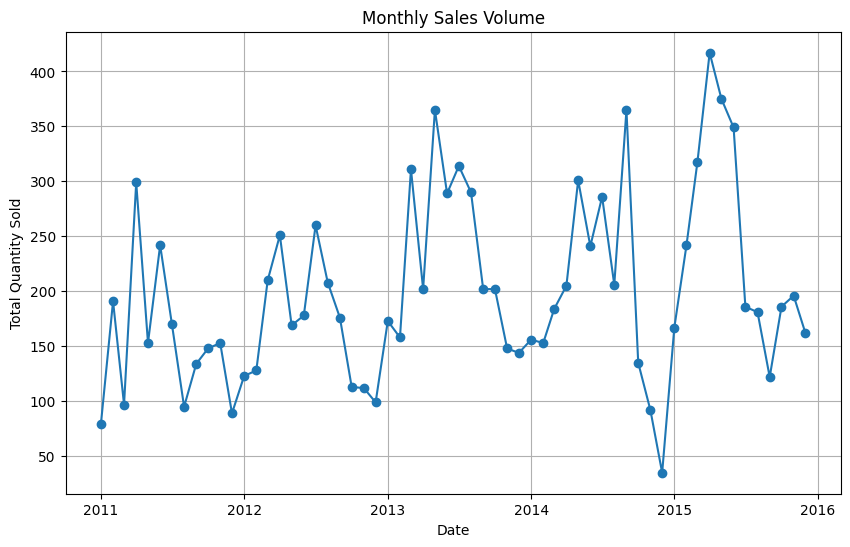

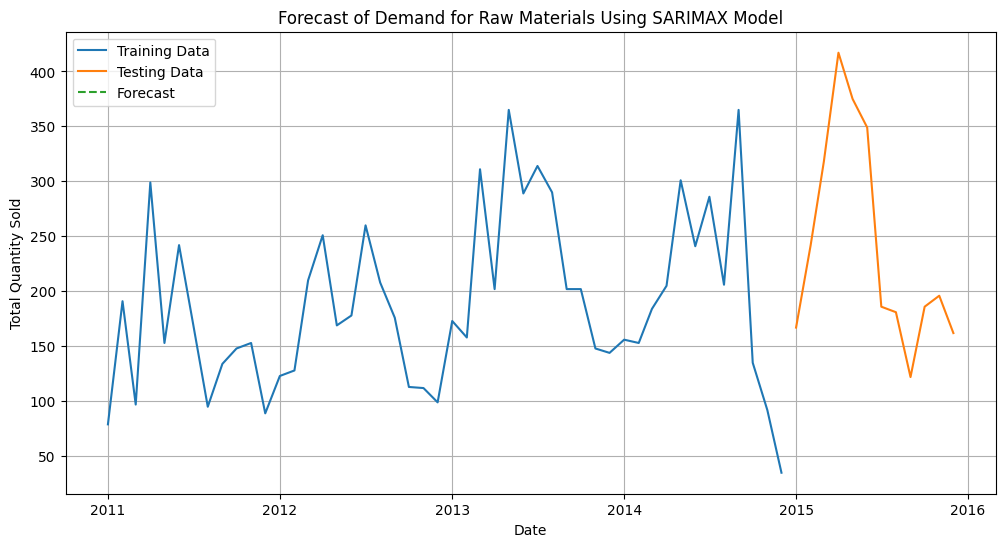

In [ ]:
warnings.filterwarnings("ignore")

# Conversion de la colonne 'order.date' en format datetime
data['order.date'] = pd.to_datetime(data['order.date'])

# Agrégation des ventes par mois pour créer une série temporelle des ventes
monthly_sales = data.groupby(data['order.date'].dt.to_period('M')).agg({'quantity_x': 'sum'})
monthly_sales.index = monthly_sales.index.to_timestamp()

monthly_sales = monthly_sales.astype(float)

# Visualiser la série temporelle des ventes
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales, marker='o')
plt.title('Monthly Sales Volume')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.grid(True)
plt.show()

# Simulation des données exogènes : tendances du marché et capacités des fournisseurs
# Exemple de variables exogènes : Market trend (tendance du marché) et supplier capacity (capacité des fournisseurs)
data['market_trend'] = np.random.normal(loc=1.0, scale=0.1, size=len(data))  # Tendance du marché simulée
data['supplier_capacity'] = np.random.choice([0.8, 1.0, 1.2], size=len(data))  # Capacité des fournisseurs simulée

# Agrégation des indicateurs par mois
monthly_market_trend = data.groupby(data['order.date'].dt.to_period('M')).agg({'market_trend': 'mean'})
monthly_supplier_capacity = data.groupby(data['order.date'].dt.to_period('M')).agg({'supplier_capacity': 'mean'})

# Création d'un DataFrame exogène en combinant les tendances du marché et la capacité des fournisseurs
exog_materials = pd.concat([monthly_market_trend, monthly_supplier_capacity], axis=1)
exog_materials.index = exog_materials.index.to_timestamp()

# Division des données en ensemble d'entraînement et de test (80% pour l'entraînement)
train_exog_materials, test_exog_materials = exog_materials[:train_size], exog_materials[train_size:]

# Ajustement d'un modèle SARIMAX avec les données exogènes (tendances du marché et capacités des fournisseurs)
sarimax_model_materials = SARIMAX(train, exog=train_exog_materials, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=False, enforce_invertibility=False)
sarimax_result_materials = sarimax_model_materials.fit()

# Prévision la demande pour les 12 prochains mois en utilisant les données exogènes
forecast_materials = sarimax_result_materials.get_forecast(steps=forecast_period, exog=test_exog_materials[:forecast_period])
forecast_series_materials = pd.Series(forecast_materials.predicted_mean, index=forecast_index)

# Visualisation des prévisions et comparer avec les données historiques
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(forecast_series_materials, label='Forecast', linestyle='--')
plt.title('Forecast of Demand for Raw Materials Using SARIMAX Model')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.legend()
plt.grid(True)
plt.show()
